# Выполнил: Вячеслав Сафронский
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.
1. Запустите A/A-тест
2. Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.
3. Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
4. Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import scipy.stats as ss
from tqdm.auto import tqdm

In [2]:
# считываем датафрейм
df_a_a = pd.read_csv('C:/Users/user/study/stat_10/hw_aa.csv', sep = ';')

In [3]:
df_a_a

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...,...
127013,127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127014,127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127015,127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127016,127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


  0%|          | 0/1000 [00:00<?, ?it/s]

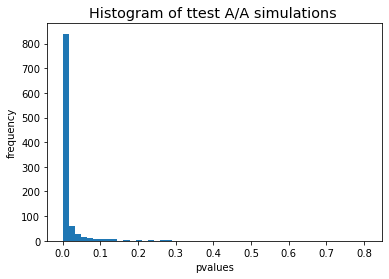

0.926

In [4]:
# 1. проводим А/A тест 

simulations = 1000
n_s = 1000
res = []


for i in tqdm(range(simulations)):
    s1 = df_a_a[df_a_a.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 = df_a_a[df_a_a.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# 2. Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

<b> FPR сильно больше альфа.

<b> <u> Сгруппируем данные по вариантам и версиям, и посмотрим на различия

In [5]:
df_a_a.groupby(['experimentVariant', 'version'], as_index = False).agg({'purchase' : 'mean', 'Unnamed: 0' : 'count' })

,experimentVariant,version,purchase,Unnamed: 0
0,0,v2.8.0,0.000993,41283
1,0,v2.9.0,0.074658,11921
2,0,v3.7.4.0,0.059943,4204
3,0,v3.8.0.0,0.057604,5694
4,1,v2.8.0,0.045606,41552
5,1,v2.9.0,0.071304,12033
6,1,v3.7.4.0,0.063018,4221
7,1,v3.8.0.0,0.062848,6110


<b> на первый взляд, сразу видно, что конверсия для версии v2.8.0 сильно отличается для двух представленных вариантов, тогда как для остальных версий различия незначительные.\
<b> <u> проверим значимость различий с помощью U-test для каждой версии.

In [6]:
# версия v2.8.0
ss.mannwhitneyu(df_a_a[(df_a_a.experimentVariant == 1) & (df_a_a.version == 'v2.8.0')]['purchase'], df_a_a[(df_a_a.experimentVariant == 0) & (df_a_a.version == 'v2.8.0')]['purchase'])

MannwhitneyuResult(statistic=895959434.5, pvalue=0.0)

In [7]:
# версия v2.9.0
ss.mannwhitneyu(df_a_a[(df_a_a.experimentVariant == 1) & (df_a_a.version == 'v2.9.0')]['purchase'], df_a_a[(df_a_a.experimentVariant == 0) & (df_a_a.version == 'v2.9.0')]['purchase'])

MannwhitneyuResult(statistic=71482120.5, pvalue=0.31829983470708123)

In [8]:
# версия v3.7.4.0
ss.mannwhitneyu(df_a_a[(df_a_a.experimentVariant == 1) & (df_a_a.version == 'v3.7.4.0')]['purchase'], df_a_a[(df_a_a.experimentVariant == 0) & (df_a_a.version == 'v3.7.4.0')]['purchase'])

MannwhitneyuResult(statistic=8899828.0, pvalue=0.5568648248217467)

In [9]:
# версия v3.8.0.0
ss.mannwhitneyu(df_a_a[(df_a_a.experimentVariant == 1) & (df_a_a.version == 'v3.8.0.0')]['purchase'], df_a_a[(df_a_a.experimentVariant == 0) & (df_a_a.version == 'v3.8.0.0')]['purchase'])

MannwhitneyuResult(statistic=17486378.0, pvalue=0.23185636638957852)

<b> значимые различия (p-value < 0.05) наблюдаются только для версии v2.8.0

<b> теперь при выполнении A/A теста исключим данные, относящиеся к версии v2.8.0

  0%|          | 0/1000 [00:00<?, ?it/s]

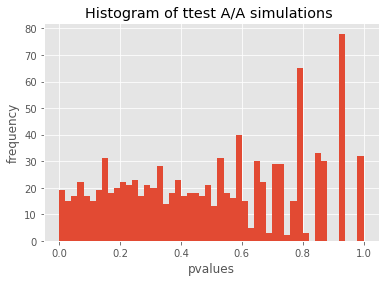

0.041

In [10]:
simulations = 1000
n_s = 1000
res = []


for i in tqdm(range(simulations)):
    s1 = df_a_a[(df_a_a.experimentVariant == 1) & (df_a_a.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df_a_a[(df_a_a.experimentVariant == 0) & (df_a_a.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

<b> <u> получаем FPR < альфа.

### Вывод:скорее всего была допущена ошибка при подготовке данных для версии v2.8.0. Необходимо перепроверить данные версии v2.8.0, или не использовать их при выполнении A/B тестов, и прочих этапах статистического анализа.